##  Testnotebook

Playaround on how to create the dataloader

In [1]:
DATASET = 'rev-moenk-22-04-01-12-00--04-07'

In [6]:
# load DF
import pandas as pd
df = pd.read_pickle('../data/' + DATASET + '/' + DATASET + '.pkl')

N = 20

In [7]:
df.head()

,index,mmsi,datetime,x,y,speed_calculated,acceleration,direction,direction_change,filename,index_column,group_index,group_count,train_index
0,1855464,10.0,2022-04-01 12:00:00+00:00,1047.616370,2007.068426,1.887704,0.00,195.218239,0.00,2022-04-01/12-00/00/10.0.npy,1855464,0,10,NaN
1,1855465,10.0,2022-04-01 12:00:01+00:00,1042.950505,2009.514714,5.268266,0.00,242.332216,-0.00,2022-04-01/12-00/01/10.0.npy,1855465,1,10,NaN
2,1855466,10.0,2022-04-01 12:00:02+00:00,1038.284640,2011.961003,5.268266,-0.00,242.332216,0.00,2022-04-01/12-00/02/10.0.npy,1855466,2,10,NaN
3,1855467,10.0,2022-04-01 12:00:03+00:00,1033.618774,2014.407291,5.268266,-0.11,242.332216,0.76,2022-04-01/12-00/03/10.0.npy,1855467,3,10,NaN
4,0,0.0,2022-04-01 12:00:04+00:00,1765.641199,2335.093460,0.000000,0.00,0.000000,0.00,2022-04-01/12-00/04/0.0.npy,0,0,0,NaN


In [8]:
# filter for rows that have N previous rows per mmsi

df.sort_values(by=['mmsi', 'datetime'], ignore_index=True, inplace=True)
# add new column named 'index_column'
df['index_column'] = df.index
df = df.groupby('mmsi').apply(lambda x: x.assign(group_index = range(len(x))))

# add group_count column that states the number of groups
df['group_count'] = df.groupby('mmsi').ngroup()

# add new column counting the rows where the group_index is greater than N
df['train_index'] = df.apply(lambda row: row.index_column - N*(1+row.group_count) if row.group_index > N else None, axis=1)


/tmp/ipykernel_16732/2365371920.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('mmsi').apply(lambda x: x.assign(group_index = range(len(x))))


torch.Size([100, 100, 3])


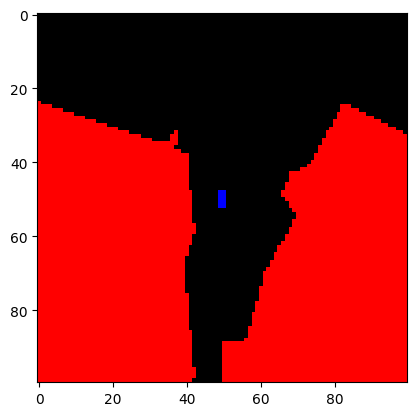

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# get highest value of train_index 
df['train_index'].max()

# get row by train_index
index = df.loc[df['train_index'] == 1].index_column.values[0]

# get rows with index_column between index-N and index
df.loc[(df['index_column'] > index-N) & (df['index_column'] <= index)]

images, states, actions = [], [], []
for index in df.loc[(df['index_column'] > index-N) & (df['index_column'] <= index)].index_column.values:
    # states.append(df.loc[index]['state'])
    # get action at index
    acceleration = df.loc[index]['acceleration']
    directionChange = df.loc[index]['direction_change']
    actions.append(torch.tensor([acceleration, directionChange], dtype=torch.float))
    # get state
    x = df.loc[index]['x']
    y = df.loc[index]['y']
    speed = df.loc[index]['speed_calculated']
    direction = df.loc[index]['direction']
    state = torch.tensor([x, y, speed, direction], dtype=torch.float)
    states.append(state)
    # load image
    image = np.load('/workspace/data/' + '/' + DATASET + '/images/'+df.loc[index]['filename'])
    # save as torch tensor
    image = torch.from_numpy(image).type(torch.uint8)
    images.append(image)



print(images[0].shape)
plt.imshow(images[2])

In [11]:
int(df['train_index'].max())

8937444

In [12]:
# normalize actions
mean_acceleration = df['acceleration'].mean()
std_acceleration = df['acceleration'].std()


In [24]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
data_dir = '/workspace/data/' + DATASET + '/'
dataframe = DATASET + '.pkl'
image_dir = '/workspace/data/' + DATASET + '/images/'
batch_size = 16
npred = 20
ncond = 10
## test dataloader  
## test output of get_batch_fm
from dataloader import DataLoader
class DataSettings:
        debug = False
        batch_size = batch_size
        npred = npred
        ncond = ncond
        width = 100
        height = 100
        device = 'gpu'
        loadImagesInMemory = False

    # Instantiate data set object
d = DataLoader(opt=DataSettings, data_dir=data_dir, dataframe=dataframe,image_dir=image_dir, seedRandom=False)
# inputs, actions, targets = d.get_batch_fm('train', npred, onlyMoving=True, onlyTurning=True)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


/workspace/PPUU/dataloader.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  self.df = self.df.groupby('mmsi').apply(lambda x: x.assign(group_index = range(len(x))))


Number of episodes: 8937984
[loading data splits: /workspace/data/rev-moenk-22-04-01-12-00--04-07//splits.pth]


In [26]:
inputs, actions, targets = d.get_batch_fm('train', npred, onlyMoving=True, onlyTurning=True)

### Unit test dataloader
Test:
 - batch size, npred and ncond is as expected
 - target and input states belong to the same ship
 - target and input states are each 1s apart
 - states are sound: action applied to state corresponds to the next state

In [6]:
# load dataframe
import pandas as pd
df = pd.read_pickle(data_dir+dataframe)

In [27]:
import torch
import dataloader_test as test
def test_dataloader(dataloader, dataframe, iterations):
    for i in range(iterations):
        inputs, actions, targets = dataloader.get_batch_fm('train', npred, onlyMoving=True, onlyTurning=True)
        everythingAlright = True
        states = torch.cat((inputs[1], targets[1]), dim=1)
        rows = test.get_rows_from_states(dataloader, states, dataframe)
        if rows != None:
            if not test.check_dimensions(inputs, actions, targets, batch_size, npred, ncond):
                print('check dimensions failed')
                return False
            if not test.check_mmsi(rows):
                print('check mmsi failed')
                return False
            if not test.check_time(rows):
                print('check time failed')
                return False
            if not test.check_speed_integration(rows):
                print('check speed integration failed')
                return False
            if not test.check_direction_integration(rows):
                print('check direction integration failed')
                # return False
            if not test.check_position_integration(rows):
                print('check position integration failed')
                return False
            # if not test.check_state_action_integration(dataloader, rows, actions, ncond):
            #     print('check state action integration failed')
            #     return False
            if not test.check_state_action_target_integration(dataloader, inputs, actions, targets, ncond):
                print('check state action integration failed')
                return False 
            
    return everythingAlright

test_dataloader(d, df, 1)
        

True

In [21]:
import utils
import torch

# test if all values are between 0 and 1
def check_normalization(inputs, actions, targets):
    max = torch.max(inputs[1])
    min = torch.min(inputs[1])
    print(max, min)



inputs, actions, targets = d.get_batch_fm('train', npred, onlyMoving=True, onlyTurning=True)
check_normalization(inputs, actions, targets)


tensor(2.6609, device='cuda:0') tensor(-2.1795, device='cuda:0')


/workspace/dataloader.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions.append(torch.tensor(action))


tensor([[ 1.5464e+00, -1.9017e+01],
        [ 1.5464e+00, -1.9017e+01],
        [ 1.5464e+00, -1.9017e+01],
        [ 1.5464e+00, -1.9017e+01],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10],
        [-1.1790e-12, -1.2860e-10]], device='cuda:0')
[1274.234     1868.567       -3.2482796    4.2784586]


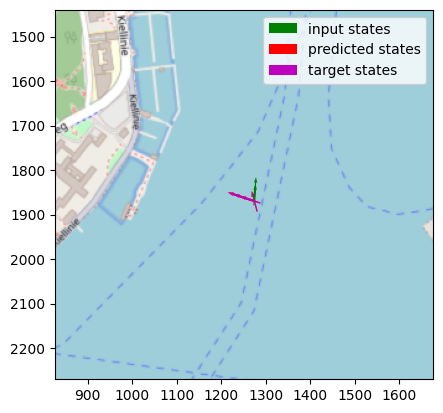

In [9]:
import utils
inputs, actions, targets = d.get_syntetic_batch_fm()
actions_denormalized = utils.denormalize_actions(actions, d.get_stats())
print(actions_denormalized[0])
utils.plot_denormalized_states(d.get_stats(), inputs, targets, targets, 0)

In [32]:
def test_syntetic_dataloader(dataloader, iterations):
    for i in range(iterations):
        inputs, actions, targets = dataloader.get_syntetic_batch_fm()
        everythingAlright = True
        states = torch.cat((inputs[1], targets[1]), dim=1)
        if not test.check_dimensions(inputs, actions, targets, batch_size, npred, ncond):
            print('check dimensions failed')
            return False
            
        if not test.check_state_action_target_integration(dataloader, inputs, actions, targets, ncond):
            print('check state action integration failed')
            return False 
            
    return everythingAlright

test_syntetic_dataloader(d, 100)

/workspace/dataloader.py:372: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions.append(torch.tensor(action))


True

In [161]:
# rows around index
index = 26268
df.loc[index-2:index+55]


,mmsi,datetime,x,y,speed_calculated,acceleration,direction,direction_change,filename
index,,,,,,,,,
26266,211223120.0,2022-04-01 17:04:53+00:00,925.591032,888.929309,0.630105,-0.00,180.000000,0.00,nbi_2022-04-01 17:04:54_211223120.0.npy
26267,211223120.0,2022-04-01 17:04:54+00:00,925.591032,889.559413,0.630105,-0.63,180.000000,-90.00,nbi_2022-04-01 17:04:55_211223120.0.npy
26268,211223120.0,2022-04-01 17:04:55+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:04:56_211223120.0.npy
26269,211223120.0,2022-04-01 17:04:56+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:04:57_211223120.0.npy
26270,211223120.0,2022-04-01 17:04:57+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:04:58_211223120.0.npy
26271,211223120.0,2022-04-01 17:04:58+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:04:59_211223120.0.npy
26272,211223120.0,2022-04-01 17:04:59+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:05:00_211223120.0.npy
26273,211223120.0,2022-04-01 17:05:00+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:05:01_211223120.0.npy
26274,211223120.0,2022-04-01 17:05:01+00:00,925.591032,889.559413,0.000000,0.00,90.000000,0.00,nbi_2022-04-01 17:05:02_211223120.0.npy


In [55]:
import datetime
# calculate current speed and save in new column
timedelta = datetime.timedelta(seconds=1)

df['dist_x'] = df['x'].diff().fillna(0.)
df['dist_y'] = df['y'].diff().fillna(0.)
df['dist'] = (df['dist_x']**2 + df['dist_y']**2)**0.5
# add column for speed in m/s (speed column is in knots)
speed_calculated = df['dist'] / timedelta.total_seconds()
df['speed_calculated'] = speed_calculated 
# print min speed_calculated
print('min speed_calculated: ',df['speed_calculated'].min())
# print max speed_calculated
print('max speed_calculated: ',df['speed_calculated'].max())
# count speed_calculated == 0
print('count speed_calculated == 0: ',df['speed_calculated'].eq(0).sum())

min speed_calculated:  0.0
max speed_calculated:  3346.5854362037576
count speed_calculated == 0:  1188


In [56]:
import numpy as np
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['direction'] = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [58]:
# add direction_change column
df['direction_change'] = df['direction'].diff().fillna(0)
# move one row up to match state
df['direction_change'] = df['direction_change'].shift(-1)

In [60]:
# clean up first and last row in group
mask_last_row_of_ship = df.mmsi != df.mmsi.shift(-1)
# mask_time_gap = df.datetime != df.datetime.shift(1) - timedelta
df['acceleration'][mask_last_row_of_ship] = 0
df['direction_change'][mask_last_row_of_ship] = 0
mask_first_row_of_ship = df.mmsi != df.mmsi.shift(1)
df['acceleration'][mask_first_row_of_ship] = 0
df['direction_change'][mask_first_row_of_ship] = 0
df['speed_calculated'][mask_first_row_of_ship] = df['speed_calculated'].shift(1)
df['direction'][mask_first_row_of_ship] = df['direction'].shift(1)

/tmp/ipykernel_2011759/4075781168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_last_row_of_ship] = 0
/tmp/ipykernel_2011759/4075781168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction_change'][mask_last_row_of_ship] = 0
/tmp/ipykernel_2011759/4075781168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_first_row_of_ship] = 0
/tmp/ipykernel_2011759/4075781168.py:8

In [61]:
# round actions to 2 decimals
df['acceleration'] = df['acceleration'].round(2)
df['direction_change'] = df['direction_change'].round(2)

In [62]:
# replace nan with 0
df['acceleration'] = df['acceleration'].fillna(0)
df['direction_change'] = df['direction_change'].fillna(0)
df['speed_calculated'] = df['speed_calculated'].fillna(0)
df['direction'] = df['direction'].fillna(0)

In [63]:
def move_around_the_clock(direction_change):
    if abs(direction_change) > 180:
        if direction_change > 0:
            return direction_change - 360
        else:
            return direction_change + 360
    else:
        return direction_change

In [64]:

# if direction change is abs > 180, set to 360 - direction_change
df['direction_change'] = df['direction_change'].apply(move_around_the_clock)

In [66]:
# reduce to important columns
df = df[['mmsi', 'datetime', 'x', 'y', 'speed_calculated', 'acceleration', 'direction', 'direction_change']]

In [144]:
# check if first action is correct
def check_first_action(inputs, actions, targets, ncond, N=0.01):
    # denormalize
    inputs = utils.denormalize_states(inputs[1], d.get_stats()).detach().cpu().numpy()
    actions = utils.denormalize_actions(actions, d.get_stats()).detach().cpu().numpy()
    targets = utils.denormalize_states(targets[1], d.get_stats()).detach().cpu().numpy()
    for i in range(inputs.shape[0]):
        last_state = inputs[i][-1]
        first_action = actions[i][0]
        first_target = targets[i][0]
        x_, y_ = integrate_state(last_state[0], last_state[1], last_state[2], first_action, last_state[3])
        if x_ > first_target[0] + N or x_ < first_target[0] - N or y_ > first_target[1] + N or y_ < first_target[1] - N:
            print('first action is not correct')
            print('last state: ', last_state)
            print('first action: ', first_action)
            print('first target: ', first_target)
            print('calculated: ', x_, y_)
            return False
    return True

check_first_action(inputs, actions, targets, ncond)

True

In [126]:
# check state integration
x = 780.884
y = 2375.79
speed = 7.62
direction = 193
acceleration = -3.75
direction_change = 2.65
action = [acceleration, direction_change]


integrate_state(x, y, speed, action, direction)

(779.8400278866311, 2379.516529515046)

In [3]:
print(actions.shape)
actions[0]

torch.Size([4, 5, 2])


tensor([[-1.4353e+01,  2.2572e+00],
        [ 1.8061e-04,  7.7855e-03],
        [ 1.8061e-04,  7.7855e-03],
        [ 4.2048e+00, -1.6737e+00],
        [ 1.8061e-04,  7.7855e-03]], device='cuda:0')

In [4]:
# denormalite actions
import utils
actions_denormilazied = utils.denormalize_actions(actions, d.get_stats())
actions_denormilazied[0]

path ferrygym ['/', '/workspace', '/usr/local/lib/python39.zip', '/usr/local/lib/python3.9', '/usr/local/lib/python3.9/lib-dynload', '', '/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages']


/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[-1.9800e+00,  8.0800e+00],
        [-9.4984e-13,  2.1545e-11],
        [-9.4984e-13,  2.1545e-11],
        [ 5.8000e-01, -6.0400e+00],
        [-9.4984e-13,  2.1545e-11]], dtype=torch.float64)

In [16]:
print(inputs[0].shape)
print(inputs[1].shape)
# denormalize states
states_denormilazied = utils.denormalize_states(inputs[1][0], d.get_stats())
states_denormilazied

torch.Size([16, 10, 3, 100, 100])
torch.Size([16, 10, 4])


NameError: name 'utils' is not defined

In [19]:
print(targets[0].shape)
print(targets[1].shape)


torch.Size([16, 5, 3, 100, 100])
torch.Size([16, 5, 4])


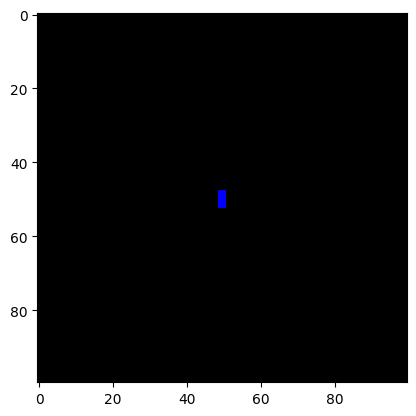

In [11]:
import matplotlib.pyplot as plt
## display last image of batch and first target
# permute back
image = inputs[0][3][9].permute(2, 1, 0).cpu()
# target = targets[0][3][0].permute(1, 2, 0)
# plt.imshow(image)
plt.imshow(image)
